# Project - Deploying a Machine Learning Model on Heroku with FastAPI

## Data Description

### Source

This data was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html
```
Donor: Ronny Kohavi and Barry Becker,
       Data Mining and Visualization
       Silicon Graphics.
       e-mail: ronnyk@sgi.com for questions.
```
* Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
* 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
* 45222 if instances with unknown values are removed (train=30162, test=15060)
* Duplicate or conflicting instances : 6
* Class probabilities for adult.all file
  * Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
  * Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)

For this project, only __train set__ of __unfiltered instanes__ is used - __32561 instances__.

### Objective
Prediction task is to determine whether a person makes over 50K a year.


### Transformations
Conversion of original data as follows:
1. Discretized gross income into two ranges with threshold 50,000.
2. Convert U.S. to US to avoid periods.
3. Convert Unknown to "?"
4. Run MLC++ GenCVFiles to generate data,test.


### Description of fnlwgt (final weight)
The weights on the CPS files are controlled to independent estimates of the
civilian noninstitutional population of the US.  These are prepared monthly
for us by Population Division here at the Census Bureau.  We use 3 sets of
controls.
These are:
1. A single cell estimate of the population 16+ for each state.
2. Controls for Hispanic Origin by age and sex.
3. Controls by Race, age and sex.
We use all three sets of controls in our weighting program and "rake" through
them 6 times so that by the end we come back to all the controls we used.
The term estimate refers to population totals derived from CPS by creating
"weighted tallies" of any specified socio-economic characteristics of the
population.

People with similar demographic characteristics should have
similar weights.  There is one important caveat to remember
about this statement.  That is that since the CPS sample is
actually a collection of 51 state samples, each with its own
probability of selection, the statement only applies within
state.

### Data values
| name | values |
|------|--------|
| __salary__ | >50K, <=50K.|
| age | continuous |
| workclass | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked |
| fnlwgt | continuous |
| education | Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool |
| education-num | continuous |
| marital-status | Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse |
| occupation | Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces |
| relationship | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried |
| race | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black |
| sex | Female, Male |
| capital-gain | continuous |
| capital-loss | continuous |
| hours-per-week | continuous |
| native-country | United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands |

## Getting raw data

In [1]:
import pandas as pd

In [2]:
DATA_PATH = '../data/census.csv'
df = pd.read_csv(DATA_PATH)
df.head()

age          workclass   fnlgt   education   education-num  \
0   39          State-gov   77516   Bachelors              13   
1   50   Self-emp-not-inc   83311   Bachelors              13   
2   38            Private  215646     HS-grad               9   
3   53            Private  234721        11th               7   
4   28            Private  338409   Bachelors              13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

    capital-gain   capital-loss   hours-per-week  native-country  salary  
0           2174              0               40   United-States   <=50K  
1              0              0               13   United-States   <=50K  
2              0              0               40   United-States   <=50K  
3              0              0               40   United-States   <=50K  
4              0              0               40            Cuba   <=50K

## Initial ETL

### Remove trailing spaces

In [3]:
print(f'Trailing spaces: \n{df.columns.tolist()[:5]} ...')
def trim(dataset):
    trim = lambda x: x.strip() if type(x) is str else x
    dataset.columns = [trim(col) for col in dataset.columns]
    return dataset.applymap(trim)

df = trim(df)
print(f'Removing spaces: \n{df.columns.tolist()[:5]} ...')

Trailing spaces: 
['age', ' workclass', ' fnlgt', ' education', ' education-num'] ...
Removing spaces: 
['age', 'workclass', 'fnlgt', 'education', 'education-num'] ...


### Replace `?` with `Unknown` for readability

In [4]:
search_func_tmp = lambda row: row.astype(str).str.contains('?', regex = False).any()
df.loc[df.apply(search_func_tmp, axis=1)].head()

age workclass   fnlgt     education  education-num         marital-status  \
14   40   Private  121772     Assoc-voc             11     Married-civ-spouse   
27   54         ?  180211  Some-college             10     Married-civ-spouse   
38   31   Private   84154  Some-college             10     Married-civ-spouse   
51   18   Private  226956       HS-grad              9          Never-married   
61   32         ?  293936       7th-8th              4  Married-spouse-absent   

       occupation   relationship                race     sex  capital-gain  \
14   Craft-repair        Husband  Asian-Pac-Islander    Male             0   
27              ?        Husband  Asian-Pac-Islander    Male             0   
38          Sales        Husband               White    Male             0   
51  Other-service      Own-child               White  Female             0   
61              ?  Not-in-family               White    Male             0   

    capital-loss  hours-per-week native-country salary  
14             0              40              ?   >50K  
27             0              60          South   >50K  
38             0              38              ?   >50K  
51             0              30              ?  <=50K  
61             0              40              ?  <=50K

In [5]:
print(f'Number of rows containing `?`: {df.apply(search_func_tmp, axis=1).sum()}')
df.replace({'?': 'Unknown'}, inplace = True)
print(f'Number of rows containing `?` after replacement: {df.apply(search_func_tmp, axis=1).sum()}')


Number of rows containing `?`: 2399
Number of rows containing `?` after replacement: 0


### Remove duplicate rows

In [6]:
df[df.duplicated(keep = False)].sort_values('fnlgt').head()

age         workclass  fnlgt     education  education-num  \
28846   39           Private  30916       HS-grad              9   
25624   39           Private  30916       HS-grad              9   
21875   49           Private  31267       7th-8th              4   
7920    49           Private  31267       7th-8th              4   
22494   49  Self-emp-not-inc  43479  Some-college             10   

           marital-status    occupation relationship   race   sex  \
28846  Married-civ-spouse  Craft-repair      Husband  White  Male   
25624  Married-civ-spouse  Craft-repair      Husband  White  Male   
21875  Married-civ-spouse  Craft-repair      Husband  White  Male   
7920   Married-civ-spouse  Craft-repair      Husband  White  Male   
22494  Married-civ-spouse  Craft-repair      Husband  White  Male   

       capital-gain  capital-loss  hours-per-week native-country salary  
28846             0             0              40  United-States  <=50K  
25624             0             0              40  United-States  <=50K  
21875             0             0              40  United-States  <=50K  
7920              0             0              40  United-States  <=50K  
22494             0             0              40  United-States  <=50K

In [7]:
print(f'Number of rows: {df.shape[0]}')
df.drop_duplicates(inplace = True)
print(f'Number of rows after duplicates drop: {df.shape[0]}')

Number of rows: 32561
Number of rows after duplicates drop: 32537


## `pandas_profiling` for initial EDA

In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## ETL (for baseline)

In [9]:
RANDOM_STATE = 48

### Columns' types

`education` and `education-num` have Pearson's correlation of 1.0, thus we remove `education-num`

In [10]:
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
num_features = ['age', 'fnlgt', 'capital-gain', 'capital-loss', 'hours-per-week']
target = 'salary'

df = df[cat_features + num_features + [target]]

### Ordinal columns' order

In [11]:
workclass_order = ['Private', 'Self-emp-inc', 'Self-emp-not-inc', 'Local-gov', 'State-gov', 'Federal-gov', 'Without-pay', 'Never-worked', 'Unknown', 'Other']
education_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate', 'Other']
marital_status_order = ['Married-civ-spouse', 'Married-AF-spouse', 'Married-spouse-absent', 'Separated', 'Divorced', 'Widowed', 'Never-married', 'Other']
relationship_order = ['Husband', 'Wife', 'Own-child', 'Unmarried', 'Not-in-family', 'Other-relative', 'Other']

cat_order = {
    'workclass': workclass_order,
    'education': education_order,
    'marital-status': marital_status_order,
    'occupation': None,
    'relationship': relationship_order,
    'race': None,
    'sex': None,
    'native-country': None
}

### One-hot encoding categorical columns

In [12]:
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder

X_cat = df[cat_features].values

encoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
X_cat = encoder.fit_transform(X_cat)

### Transforming numerical columns

In [13]:
X_num = df[num_features].values

### Merging tranformed columns

In [14]:
import numpy as np

X = np.concatenate([X_num, X_cat], axis=1)

print(f'Transformed data shape: {X.shape}')

Transformed data shape: (32537, 107)


### Transforming target column - `price`

In [15]:
from sklearn.preprocessing import LabelEncoder

y = df[target]

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

for i, c in enumerate(target_encoder.classes_):
    print(f'Label `{c}` encoded into: `{i}`')

print(f'Transformed target shape: {y.shape}')

Label `<=50K` encoded into: `0`
Label `>50K` encoded into: `1`
Transformed target shape: (32537,)


## Baseline model(s)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = RANDOM_STATE)

### Gradient Boosting classifier (sklearn)

F1 beta score        : 0.677
Precision (PPV) score: 0.771
Recal (TPR) score    : 0.604


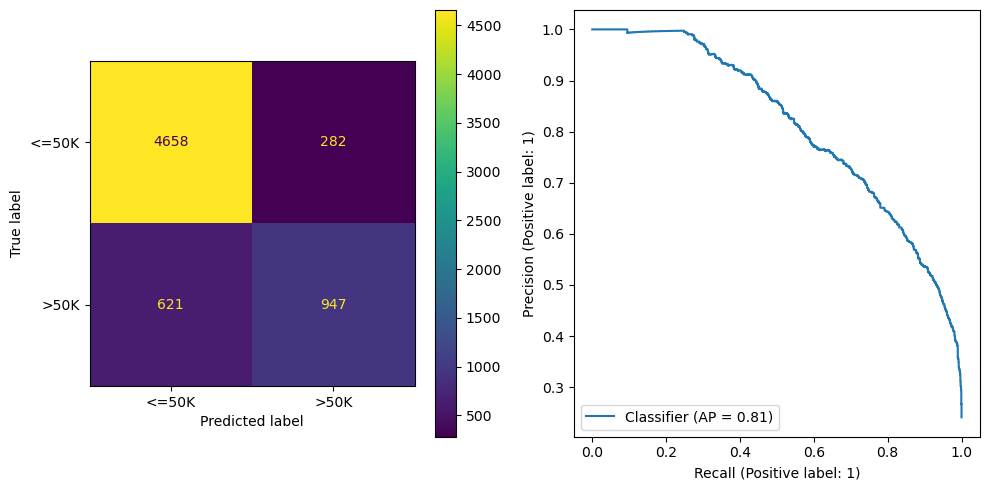

In [17]:
from sklearn.metrics import fbeta_score, precision_score, recall_score, ConfusionMatrixDisplay, PrecisionRecallDisplay

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state = RANDOM_STATE)
gbc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = gbc.predict(X_test)
y_pred_proba = gbc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

### AdaBoost classifier (sklearn)

F1 beta score        : 0.681
Precision (PPV) score: 0.747
Recal (TPR) score    : 0.626


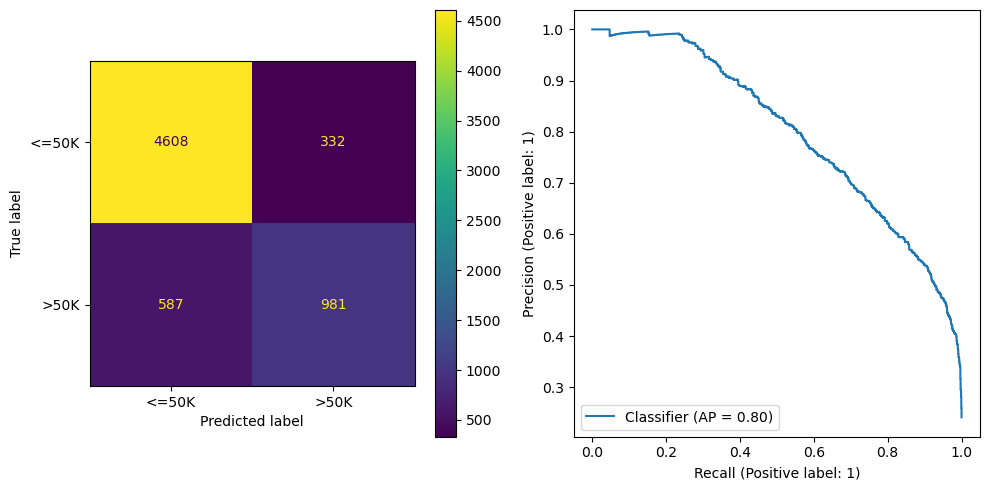

In [18]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(random_state = RANDOM_STATE)
abc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = abc.predict(X_test)
y_pred_proba = abc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

### Random forest classifier

F1 beta score        : 0.683
Precision (PPV) score: 0.723
Recal (TPR) score    : 0.647


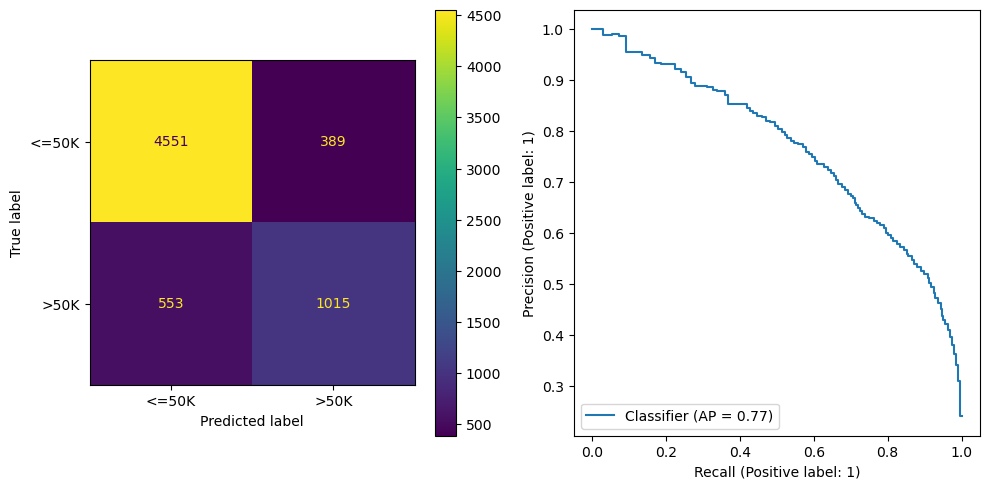

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = RANDOM_STATE)
rfc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

### Logistic regression classifier

F1 beta score        : 0.393
Precision (PPV) score: 0.730
Recal (TPR) score    : 0.269


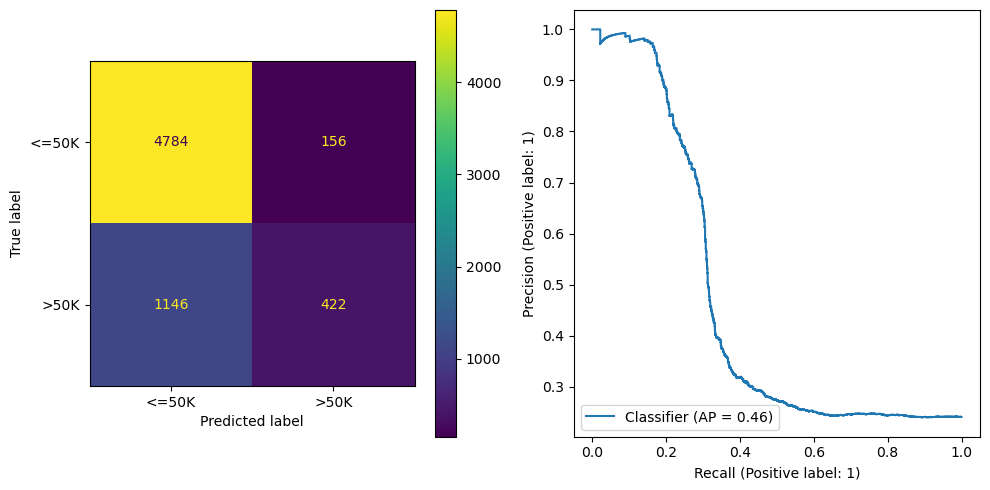

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = RANDOM_STATE)
lr.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

### Catboost - does not require preprocessing of categorical variables

#### ETL for catboost

In [21]:
y = df[target]
X = df.loc[:, df.columns != target]

y = target_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = RANDOM_STATE)

#### Model training

F1 beta score        : 0.718
Precision (PPV) score: 0.767
Recal (TPR) score    : 0.675


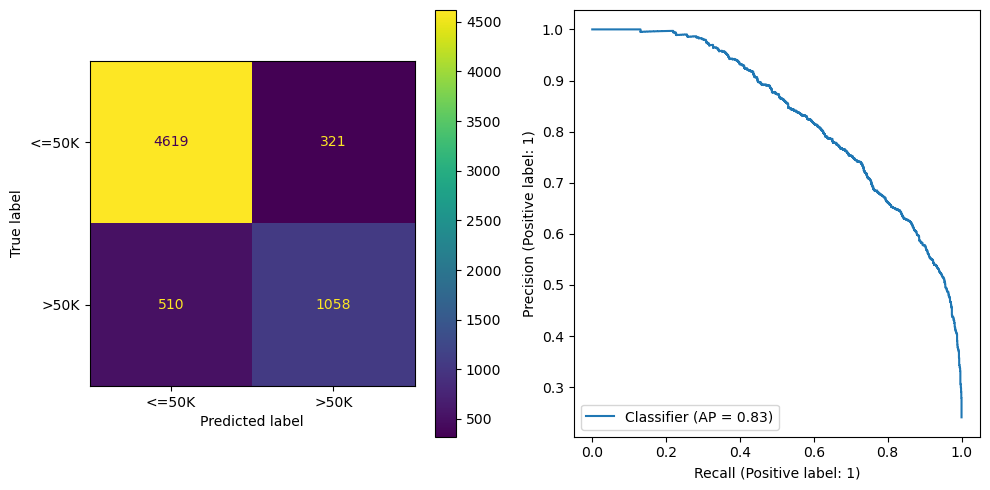

In [22]:
from catboost import CatBoostClassifier


cbc = CatBoostClassifier(
    cat_features = cat_features,
    random_seed = RANDOM_STATE,
    verbose = False)

# train the model
cbc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = cbc.predict(X_test)
y_pred_proba = cbc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

## EDA

### Target feature plots

In [23]:
import seaborn as sns
sns.set_theme(style="darkgrid")

#### Categorical variables - Plots without percentile filtration

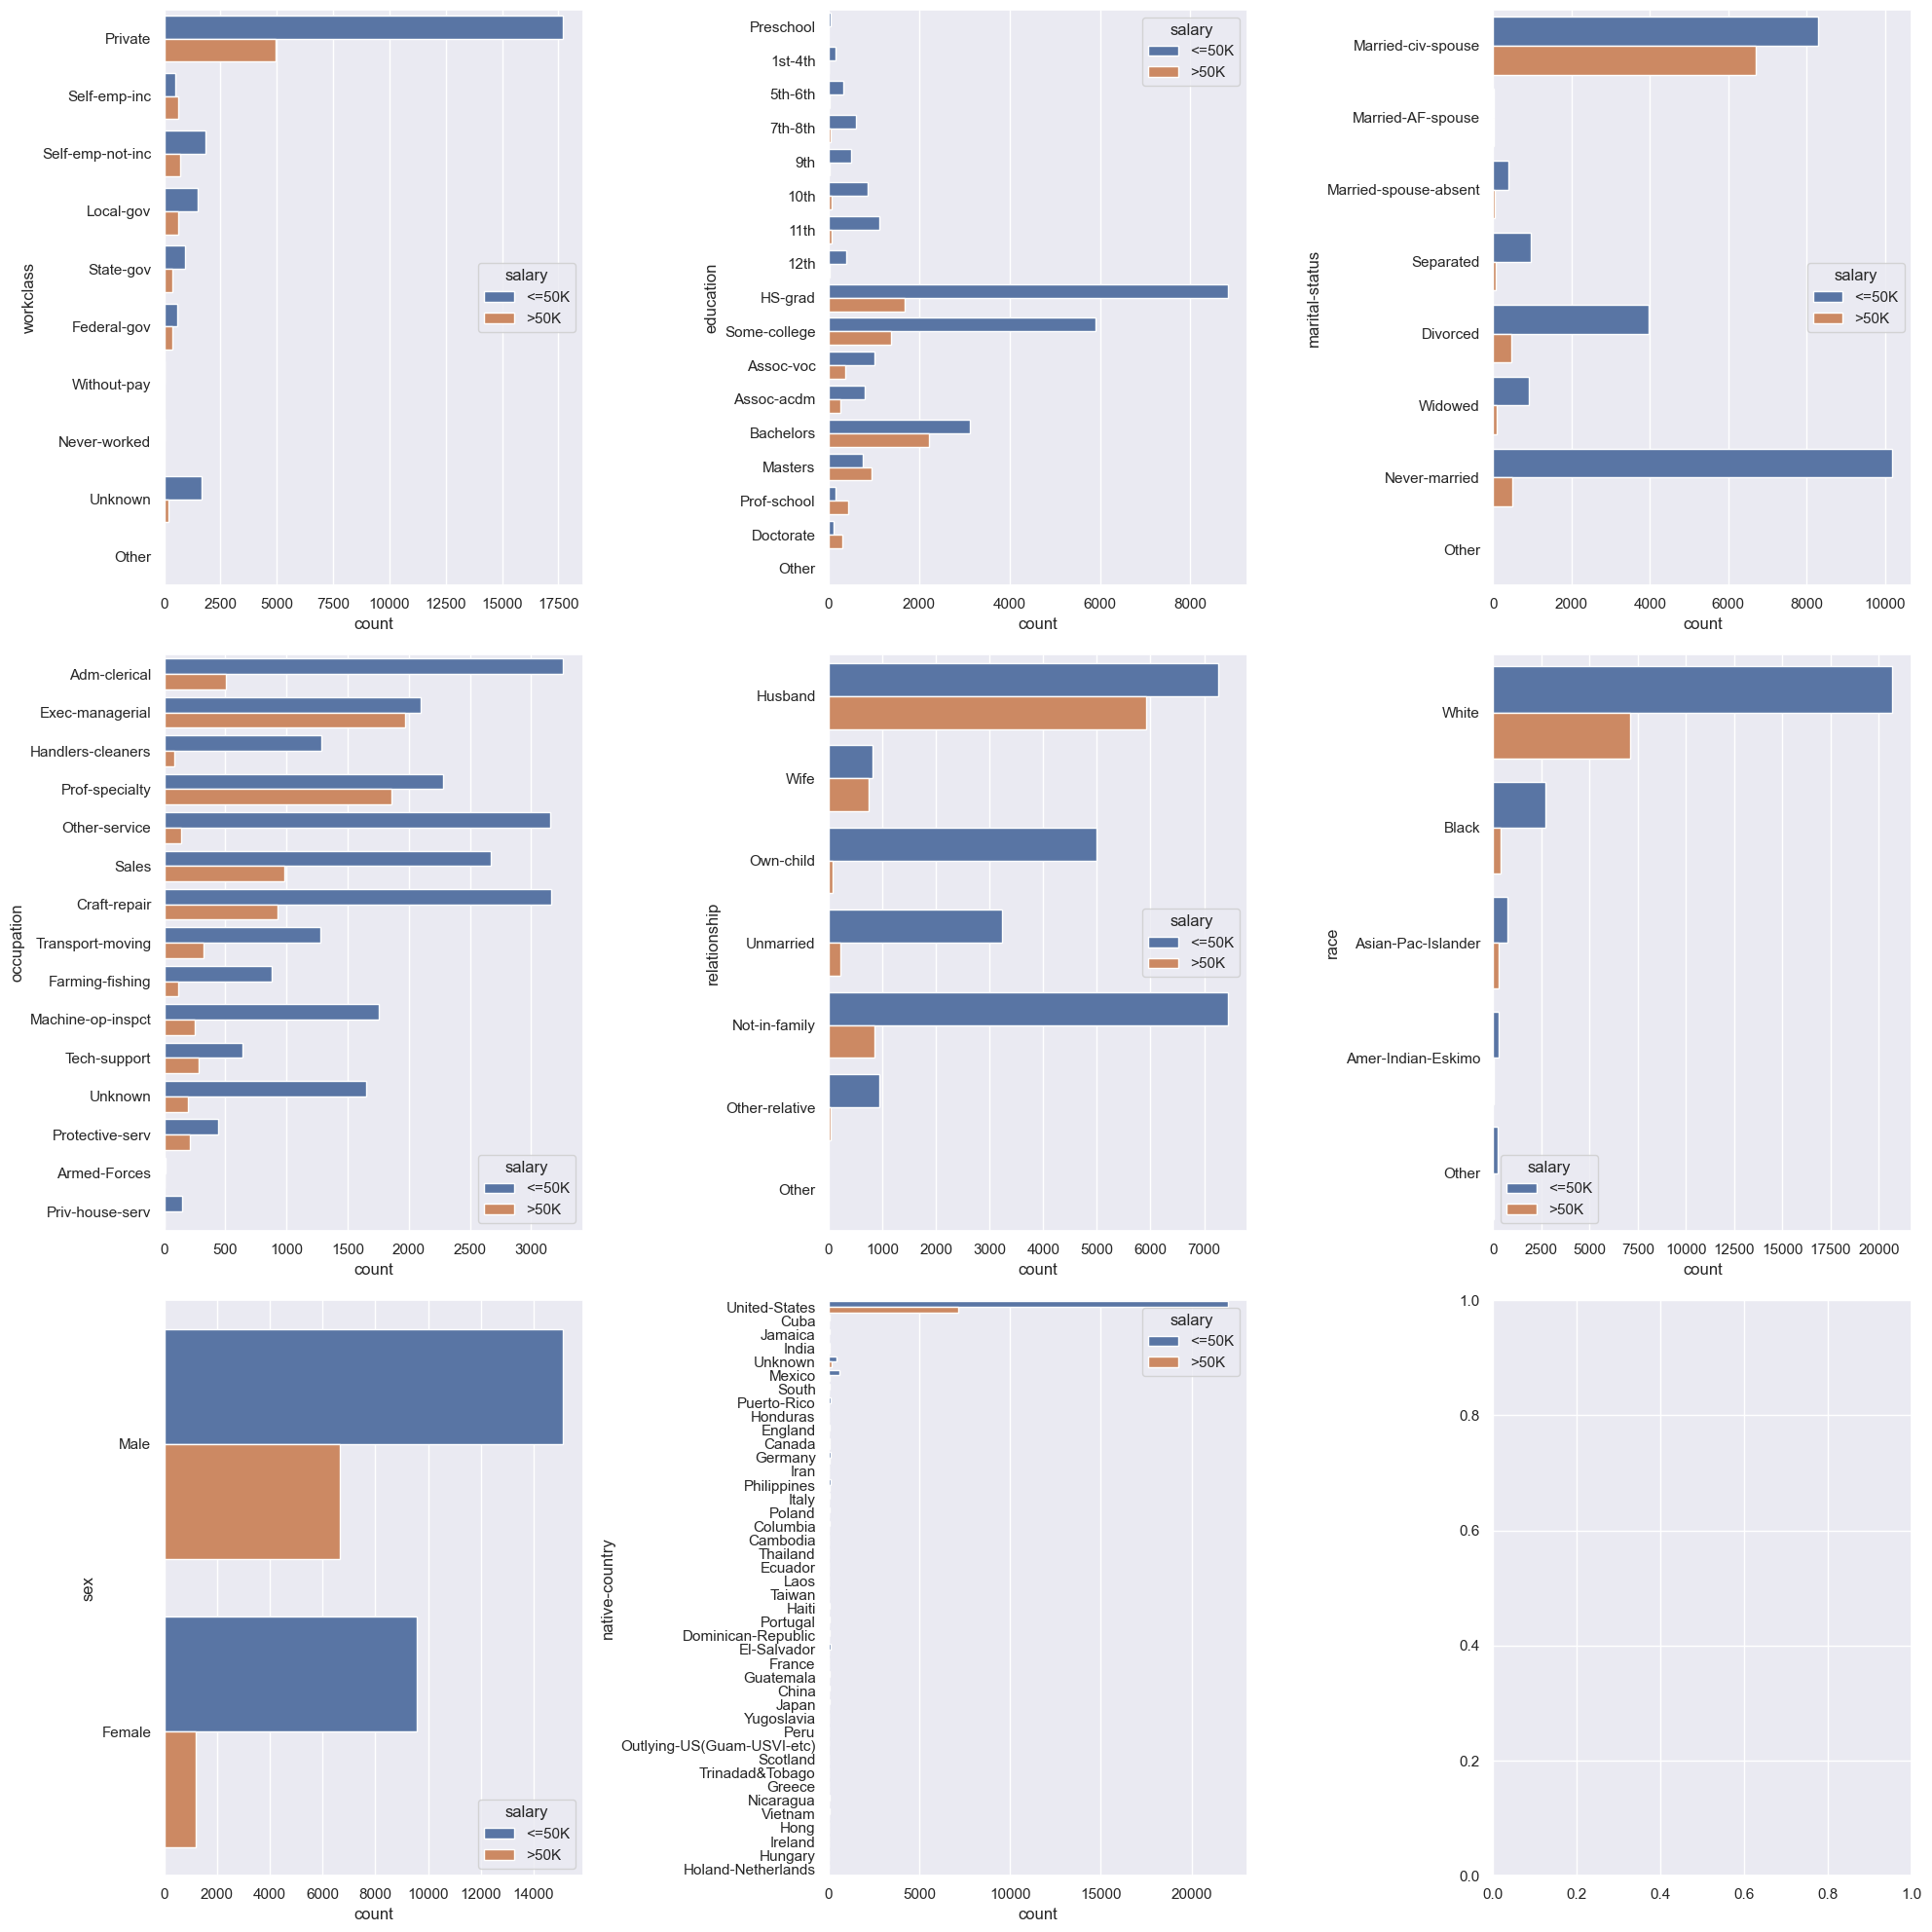

In [24]:
fig, axes = plt.subplots((len(cat_features) + 2) // 3, 3, figsize = (20, 20))

for i, cat_f in enumerate(cat_features):
    ix = i % 3
    iy = i // 3
    sns.countplot(
        data = df,
        y = cat_f,
        hue = target,
        ax = axes[iy, ix],
        order = cat_order[cat_f]
    )

plt.tight_layout()
plt.show()


#### Categorical variables - Plots with percentile filtration

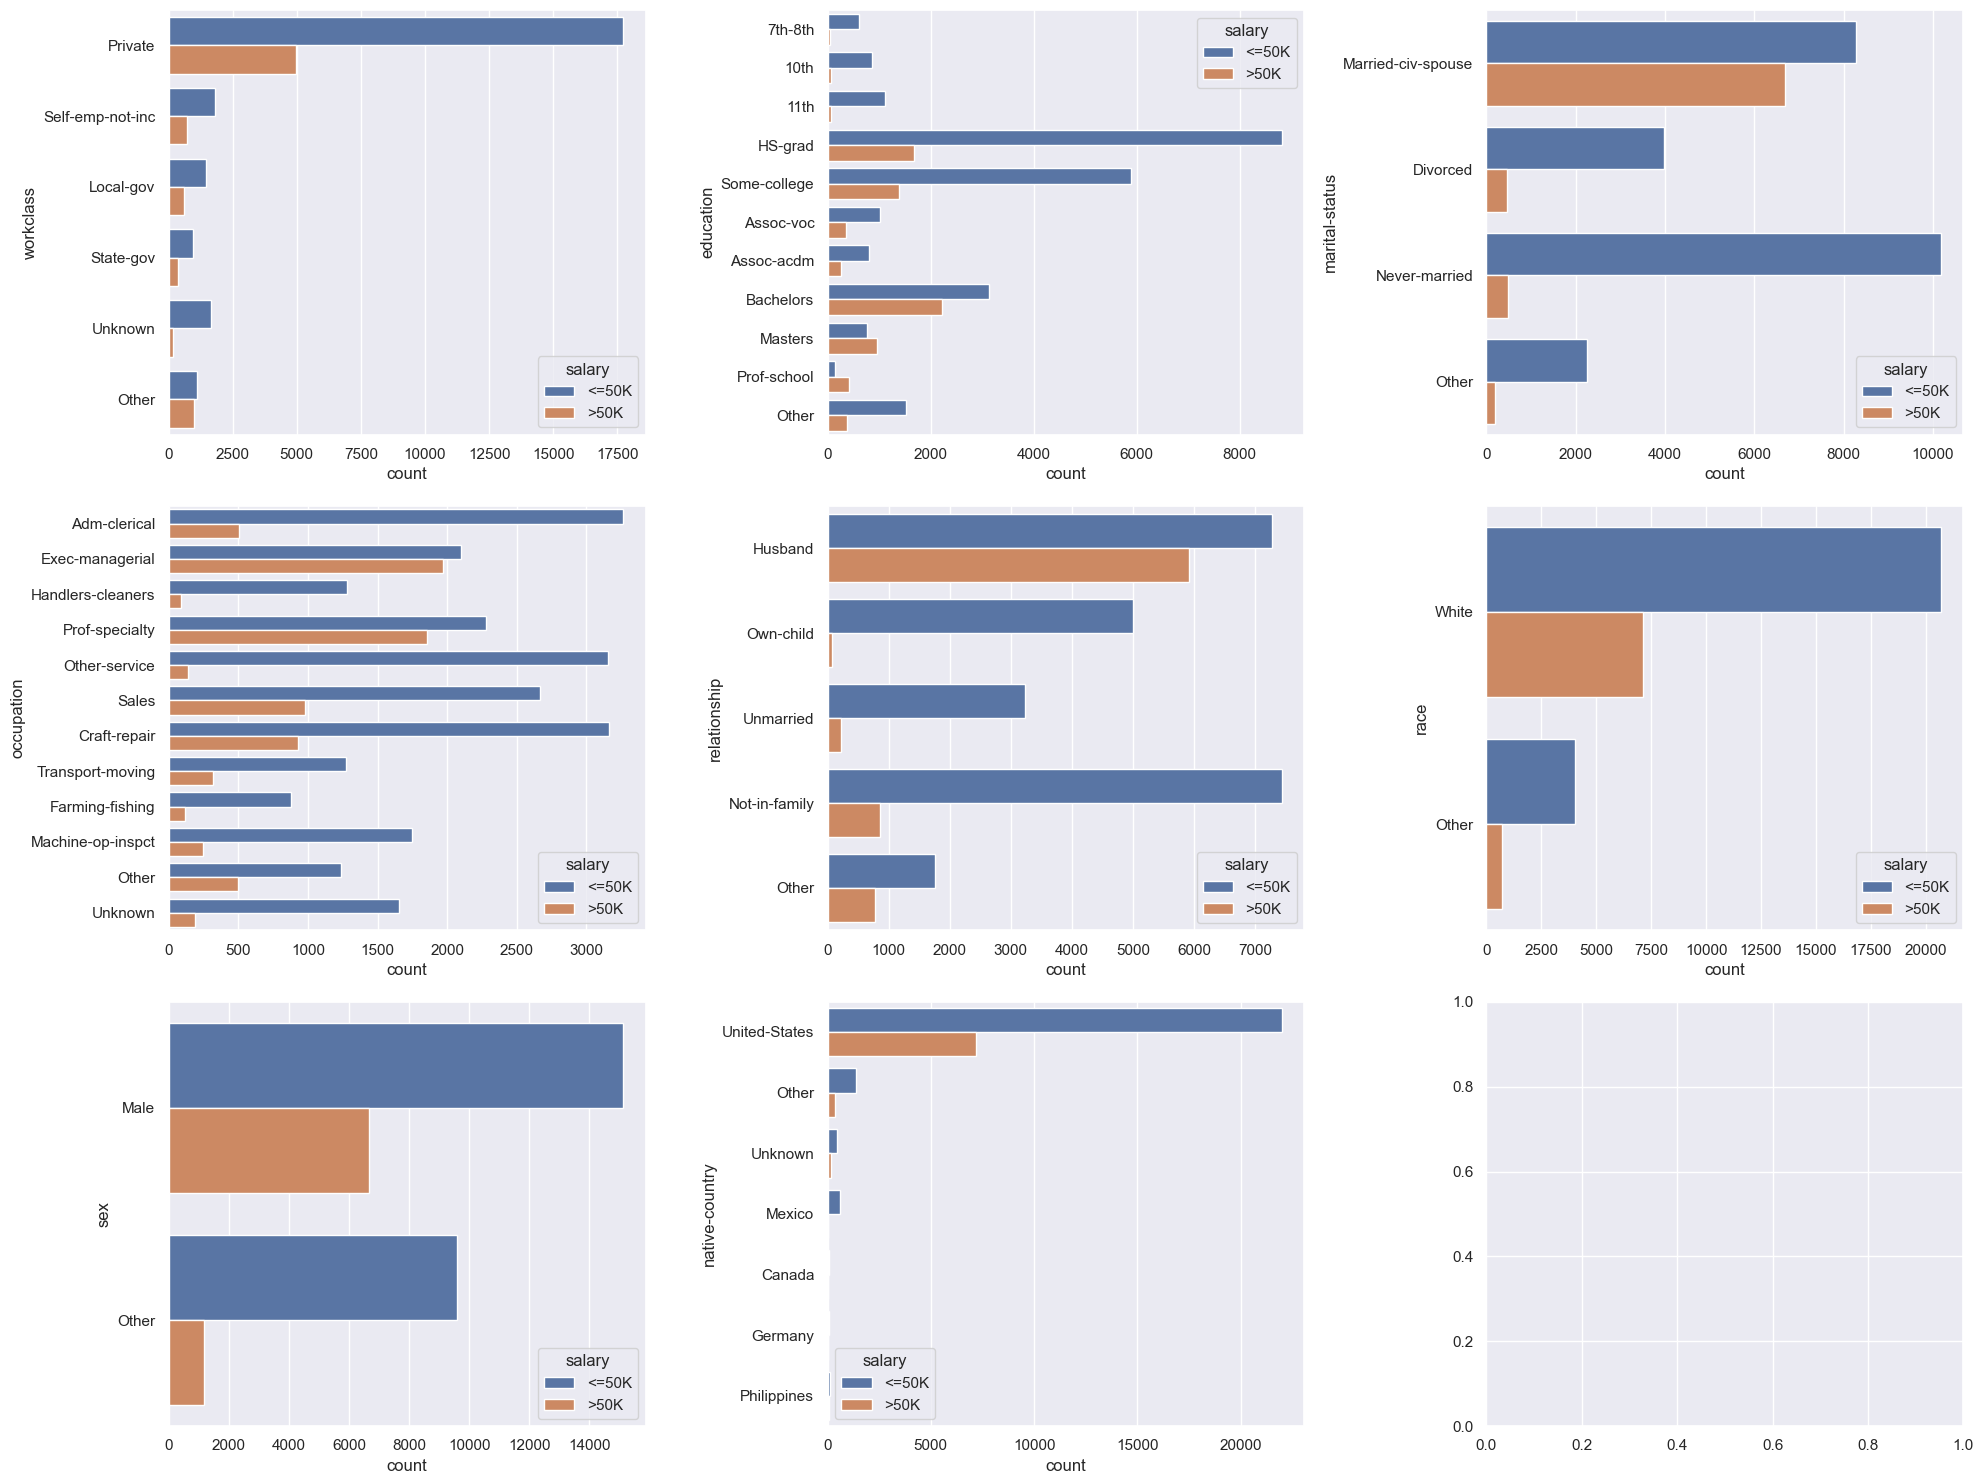

In [25]:
def _transform_get_percentile(df, cat_f, target, percentile = 0.95):
    
    tmp_df = df[[cat_f, target]].copy(deep = True)
    value_counts = tmp_df[cat_f].value_counts()
    within_percentile = value_counts[value_counts.cumsum() <= percentile * tmp_df.shape[0]].index.tolist()
    tmp_df[cat_f] = tmp_df[cat_f].map(lambda x: x if x in within_percentile else 'Other')

    return tmp_df


fig, axes = plt.subplots((len(cat_features) + 2) // 3, 3, figsize = (20, 15))

for i, cat_f in enumerate(cat_features):
    tmp_df = _transform_get_percentile(df, cat_f, target)
    ix = i % 3
    iy = i // 3
    tmp_order = [v for v in cat_order[cat_f] if v in tmp_df[cat_f].unique()] \
                if cat_order[cat_f] is not None else None
    sns.countplot(
        data = tmp_df,
        y = cat_f,
        hue = target,
        ax = axes[iy, ix],
        order = tmp_order
    )

plt.tight_layout()
plt.show()


#### Numeric variables

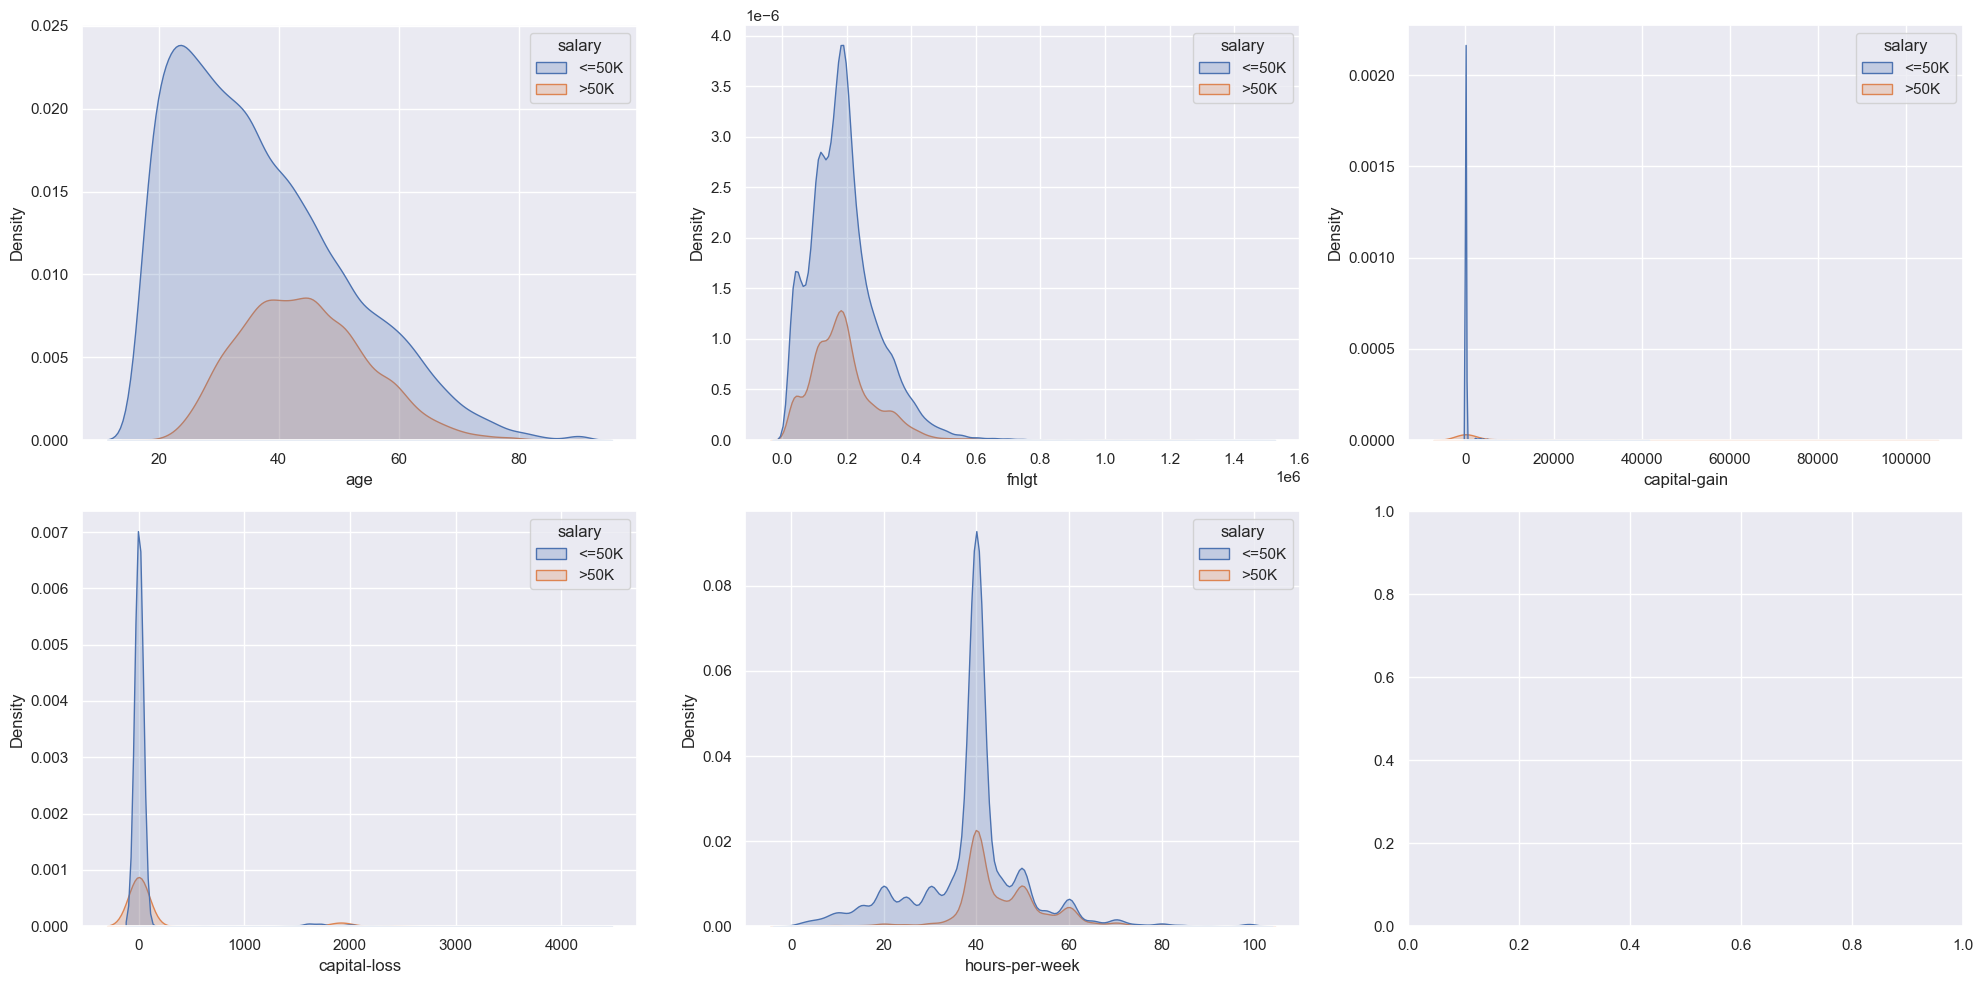

In [26]:
fig, axes = plt.subplots((len(num_features) + 2) // 3, 3, figsize = (20, 10))

for i, num_f in enumerate(num_features):
    ix = i % 3
    iy = i // 3
    sns.kdeplot(
        data = df, 
        x = num_f,
        hue = target,
        ax = axes[iy, ix],
        fill=True
    )


plt.tight_layout()
plt.show()


### Independent variables plots

#### `age`

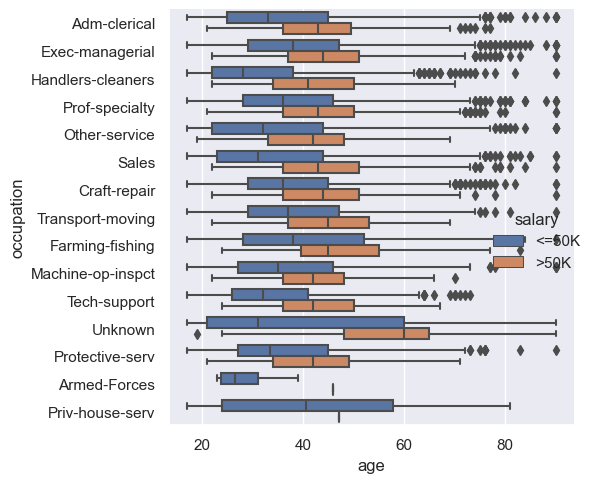

In [27]:
sns.catplot(
    x = 'age',
    y = 'occupation',
    hue = target,
    kind = 'box',
    data = df
)

plt.tight_layout()
plt.show()

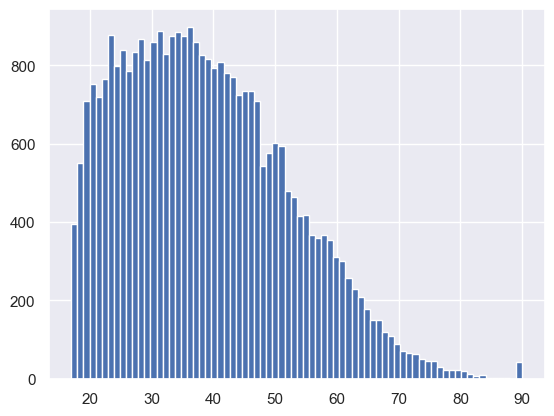

In [28]:
age = df['age']
assert age.between(17, 90).all()
age.hist(bins = 74)
plt.show()

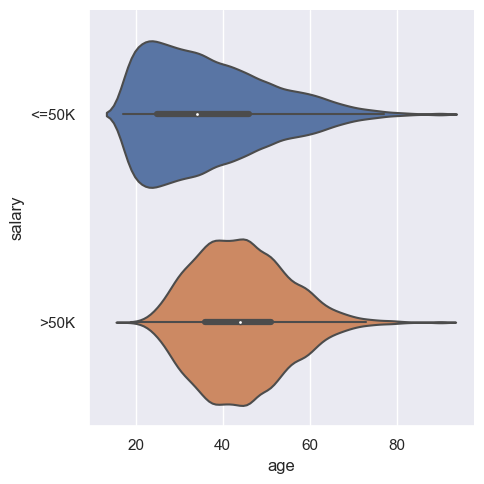

In [29]:
sns.catplot(
    x='age',
    y='salary',
    kind='violin',
    data=df
 )
plt.show()

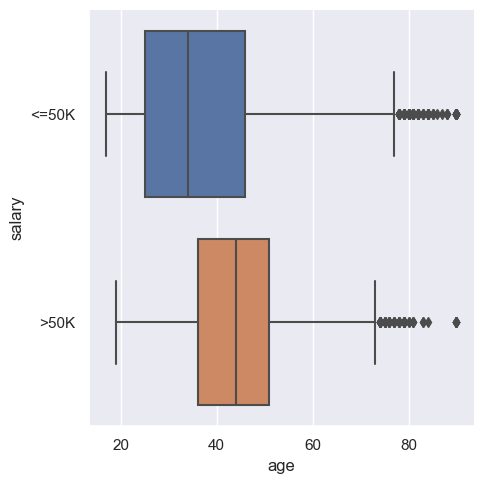

In [30]:
sns.catplot(
    x='age',
    y='salary',
    kind='box',
    data=df
 )
plt.show()

#### `workclass`

In [31]:
workclass = df['workclass']
workclass.value_counts()

Private             22673
Self-emp-not-inc     2540
Local-gov            2093
Unknown              1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

#### `fnlgt`

In [32]:
fnlgt = df['fnlgt']
pd.DataFrame(data = {'10 largest': fnlgt.nlargest(10).values, '10 smallest': fnlgt.nsmallest(10).values})

10 largest  10 smallest
0     1484705        12285
1     1455435        13769
2     1366120        14878
3     1268339        18827
4     1226583        19214
5     1184622        19302
6     1161363        19302
7     1125613        19302
8     1097453        19302
9     1085515        19302

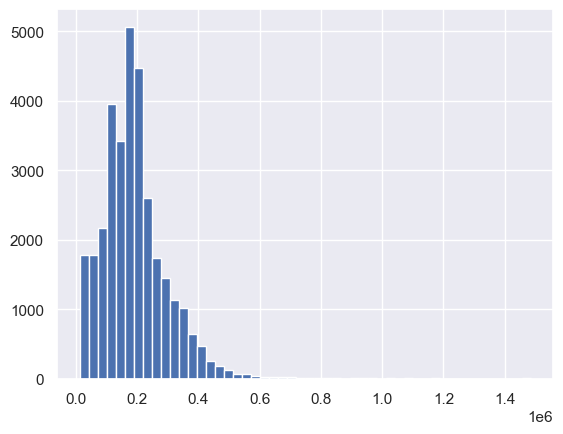

In [33]:
fnlgt.hist(bins = 50)
plt.show()

#### `education`

In [34]:
education = df['education']
education.value_counts()

HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           645
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           332
1st-4th           166
Preschool          50
Name: education, dtype: int64

#### `education-num`

In [35]:
education_num = df['education-num']
education_num.value_counts()

KeyError: 'education-num'

#### `marital-status`

In [ ]:
marital_status = df['marital-status']
marital_status.value_counts()

#### `occupation`

In [ ]:
occupation = df['occupation']
occupation.value_counts()

#### `relationship`

In [ ]:
relationship = df['relationship']
relationship.value_counts()

#### `race`

In [ ]:
race = df['race']
race.value_counts()

#### `sex`

In [ ]:
sex = df['sex']
sex.value_counts()

#### `capital-gain`

In [ ]:
capital_gain = df['capital-gain']
pd.DataFrame(data = {'10 largest': capital_gain.nlargest(10).values, '10 smallest': capital_gain.nsmallest(10).values})

In [ ]:
capital_gain[(capital_gain != 0) & (capital_gain != 99999)].hist(bins = 50)
plt.show()

#### `capital-loss`

In [ ]:
capital_loss = df['capital-loss']
pd.DataFrame(data = {'10 largest': capital_loss.nlargest(10).values, '10 smallest': capital_loss.nsmallest(10).values})

In [ ]:
capital_loss[capital_loss != 0].hist(bins = 50)
plt.show()

#### `hours-per-week`

In [36]:
hours_per_week = df['hours-per-week']
pd.DataFrame(data = {'10 largest': hours_per_week.nlargest(10).values, '10 smallest': hours_per_week.nsmallest(10).values})

10 largest  10 smallest
0          99            1
1          99            1
2          99            1
3          99            1
4          99            1
5          99            1
6          99            1
7          99            1
8          99            1
9          99            1

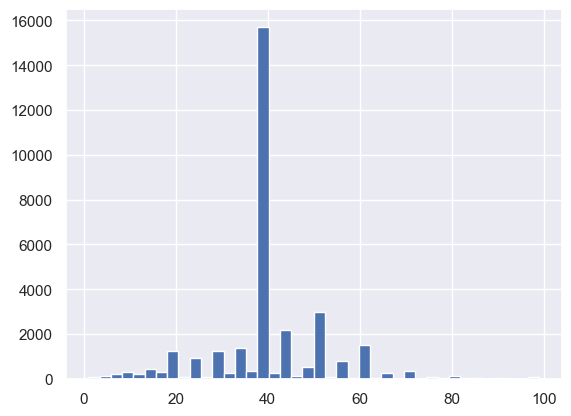

In [37]:
hours_per_week.hist(bins = 40)
plt.show()

#### `native-country`

In [38]:
native_country = df['native-country']
native_country.value_counts()

United-States                 29153
Mexico                          639
Unknown                         582
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Japan                            62
Guatemala                        62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

## Model bias

### Preprocessing

In [39]:
y = df[target]
X = df.loc[:, df.columns != target]

y = target_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = RANDOM_STATE)

df_aq = X_test.copy(deep = True)

In [40]:
df_aq['label_value'] = y_test
df_aq['score'] = y_pred
df_aq.head()

workclass     education      marital-status         occupation  \
28822      Private  Some-college  Married-civ-spouse              Sales   
24851      Private  Some-college       Never-married  Handlers-cleaners   
15880      Private     Bachelors  Married-civ-spouse     Prof-specialty   
27638    Local-gov          10th  Married-civ-spouse      Other-service   
26787  Federal-gov       HS-grad  Married-civ-spouse       Craft-repair   

        relationship   race   sex native-country  age   fnlgt  capital-gain  \
28822        Husband  White  Male  United-States   32  175856             0   
24851  Not-in-family  White  Male  United-States   23  173679             0   
15880        Husband  White  Male  United-States   56  345730             0   
27638        Husband  White  Male  United-States   26  159662             0   
26787        Husband  White  Male  United-States   33  188246             0   

       capital-loss  hours-per-week  label_value  score  
28822             0              40            0      0  
24851             0              40            0      0  
15880             0              45            1      1  
27638             0              40            0      0  
26787             0              40            0      0

In [41]:
qcut_cols = [n for n in num_features if n not in ['fnlgt', 'education-num', 'capital-gain', 'capital-loss']]
for num_f in qcut_cols:
    df_aq[num_f + '-qcut'] = pd.qcut(df_aq[num_f], 10, duplicates = 'drop').astype(str)
aq_cols = cat_features + [n + '-qcut' for n in qcut_cols] + ['label_value', 'score']
df_aq = df_aq.loc[:, aq_cols]
df_aq.head()

workclass     education      marital-status         occupation  \
28822      Private  Some-college  Married-civ-spouse              Sales   
24851      Private  Some-college       Never-married  Handlers-cleaners   
15880      Private     Bachelors  Married-civ-spouse     Prof-specialty   
27638    Local-gov          10th  Married-civ-spouse      Other-service   
26787  Federal-gov       HS-grad  Married-civ-spouse       Craft-repair   

        relationship   race   sex native-country      age-qcut  \
28822        Husband  White  Male  United-States  (30.0, 34.0]   
24851  Not-in-family  White  Male  United-States  (22.0, 26.0]   
15880        Husband  White  Male  United-States  (50.0, 58.0]   
27638        Husband  White  Male  United-States  (22.0, 26.0]   
26787        Husband  White  Male  United-States  (30.0, 34.0]   

      hours-per-week-qcut  label_value  score  
28822        (35.0, 40.0]            0      0  
24851        (35.0, 40.0]            0      0  
15880        (40.0, 50.0]            1      1  
27638        (35.0, 40.0]            0      0  
26787        (35.0, 40.0]            0      0

In [42]:
# merge small group frequencies
def _transform_get_percentile(df, cat_f, target, percentile = 0.95):
    
    tmp_df = df[[cat_f, target]].copy(deep = True)
    value_counts = tmp_df[cat_f].value_counts()
    within_percentile = value_counts[value_counts.cumsum() <= percentile * tmp_df.shape[0]].index.tolist()
    tmp_df[cat_f] = tmp_df[cat_f].map(lambda x: x if x in within_percentile else 'Other')

    return tmp_df

for cat_f in cat_features:
    df_aq[cat_f] = _transform_get_percentile(df, cat_f, target)[cat_f]

### Biases across subgroups

In [43]:
from aequitas.group import Group
from aequitas.bias import Bias 
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

aqp = Plot()

In [44]:
group = Group()
xtab, idxs = group.get_crosstabs(df_aq)
absolute_metrics = group.list_absolute_metrics(xtab)

# xtab[[col for col in xtab.columns if col not in absolute_metrics + ['model_id', 'score_threshold', 'k', 'pp', 'pn', 'group_label_pos', 'group_label_neg']]]
group_size_fr = xtab['group_size'] / xtab['total_entities']
xtab.loc[group_size_fr >= 0.05, ['attribute_name', 'attribute_value', 'tp', 'fp', 'tn', 'fn', 'tpr', 'tnr', 'precision', 'npv', 'group_size', 'total_entities']].round(2)

attribute_name     attribute_value   tp   fp    tn   fn   tpr   tnr  \
0             workclass           Local-gov   95   34   265   34  0.74  0.89   
1             workclass               Other  154   64   152   34  0.82  0.70   
2             workclass             Private  657  176  3391  353  0.65  0.95   
3             workclass    Self-emp-not-inc   89   25   332   52  0.63  0.93   
5             workclass             Unknown   16    6   303   26  0.38  0.98   
11            education           Bachelors  353  116   560   99  0.78  0.83   
12            education             HS-grad  122   35  1696  196  0.38  0.98   
13            education             Masters  188   43   116   18  0.91  0.73   
14            education               Other   62   15   297   14  0.82  0.95   
16            education        Some-college  158   68  1104  111  0.59  0.94   
17       marital-status            Divorced   41   13   807   52  0.44  0.98   
18       marital-status  Married-civ-spouse  956  297  1348  377  0.72  0.82   
19       marital-status       Never-married   47   11  2047   56  0.46  0.99   
20       marital-status               Other   14    0   417   25  0.36  1.00   
21           occupation        Adm-clerical   59   33   643   33  0.64  0.95   
22           occupation        Craft-repair   81   21   606  106  0.43  0.97   
23           occupation     Exec-managerial  311   93   358   67  0.82  0.79   
26           occupation   Machine-op-inspct   16    2   356   18  0.47  0.99   
27           occupation               Other   81   25   207   27  0.75  0.89   
28           occupation       Other-service    8    4   635   22  0.27  0.99   
29           occupation      Prof-specialty  324   99   377   64  0.84  0.79   
30           occupation               Sales  134   36   474   73  0.65  0.93   
32           occupation             Unknown   16    6   305   26  0.38  0.98   
33         relationship             Husband  832  257  1197  337  0.71  0.82   
34         relationship       Not-in-family   77   19  1501   98  0.44  0.99   
35         relationship               Other  128   40   312   37  0.78  0.89   
36         relationship           Own-child    5    1  1006    8  0.38  1.00   
37         relationship           Unmarried   16    4   603   30  0.35  0.99   
38                 race               Other   87   32   773   47  0.65  0.96   
39                 race               White  971  289  3846  463  0.68  0.93   
40                  sex                Male  899  273  2774  420  0.68  0.91   
41                  sex               Other  159   48  1845   90  0.64  0.97   
47       native-country       United-States  972  293  4111  476  0.67  0.93   
49             age-qcut      (16.999, 22.0]    0    0   771    2  0.00  1.00   
50             age-qcut        (22.0, 26.0]   11    3   627   23  0.32  1.00   
51             age-qcut        (26.0, 30.0]   58   18   531   50  0.54  0.97   
52             age-qcut        (30.0, 34.0]   99   44   506   49  0.67  0.92   
53             age-qcut        (34.0, 37.0]  123   25   361   59  0.68  0.94   
54             age-qcut        (37.0, 41.0]  144   45   401   58  0.71  0.90   
55             age-qcut        (41.0, 45.0]  173   46   340   67  0.72  0.88   
56             age-qcut        (45.0, 50.0]  170   57   340   74  0.70  0.86   
57             age-qcut        (50.0, 58.0]  181   52   349   62  0.74  0.87   
58             age-qcut        (58.0, 90.0]   99   31   393   66  0.60  0.93   
59  hours-per-week-qcut       (0.999, 24.0]   23    6   610   26  0.47  0.99   
60  hours-per-week-qcut        (24.0, 35.0]   49   17   602   31  0.61  0.97   
61  hours-per-week-qcut        (35.0, 40.0]  414  127  2436  253  0.62  0.95   
62  hours-per-week-qcut        (40.0, 50.0]  347   92   607  121  0.74  0.87   
64  hours-per-week-qcut        (55.0, 99.0]  156   59   279   62  0.72  0.83   

    precision   npv  group_size  total_entities  
0        0.74  0.89         428       

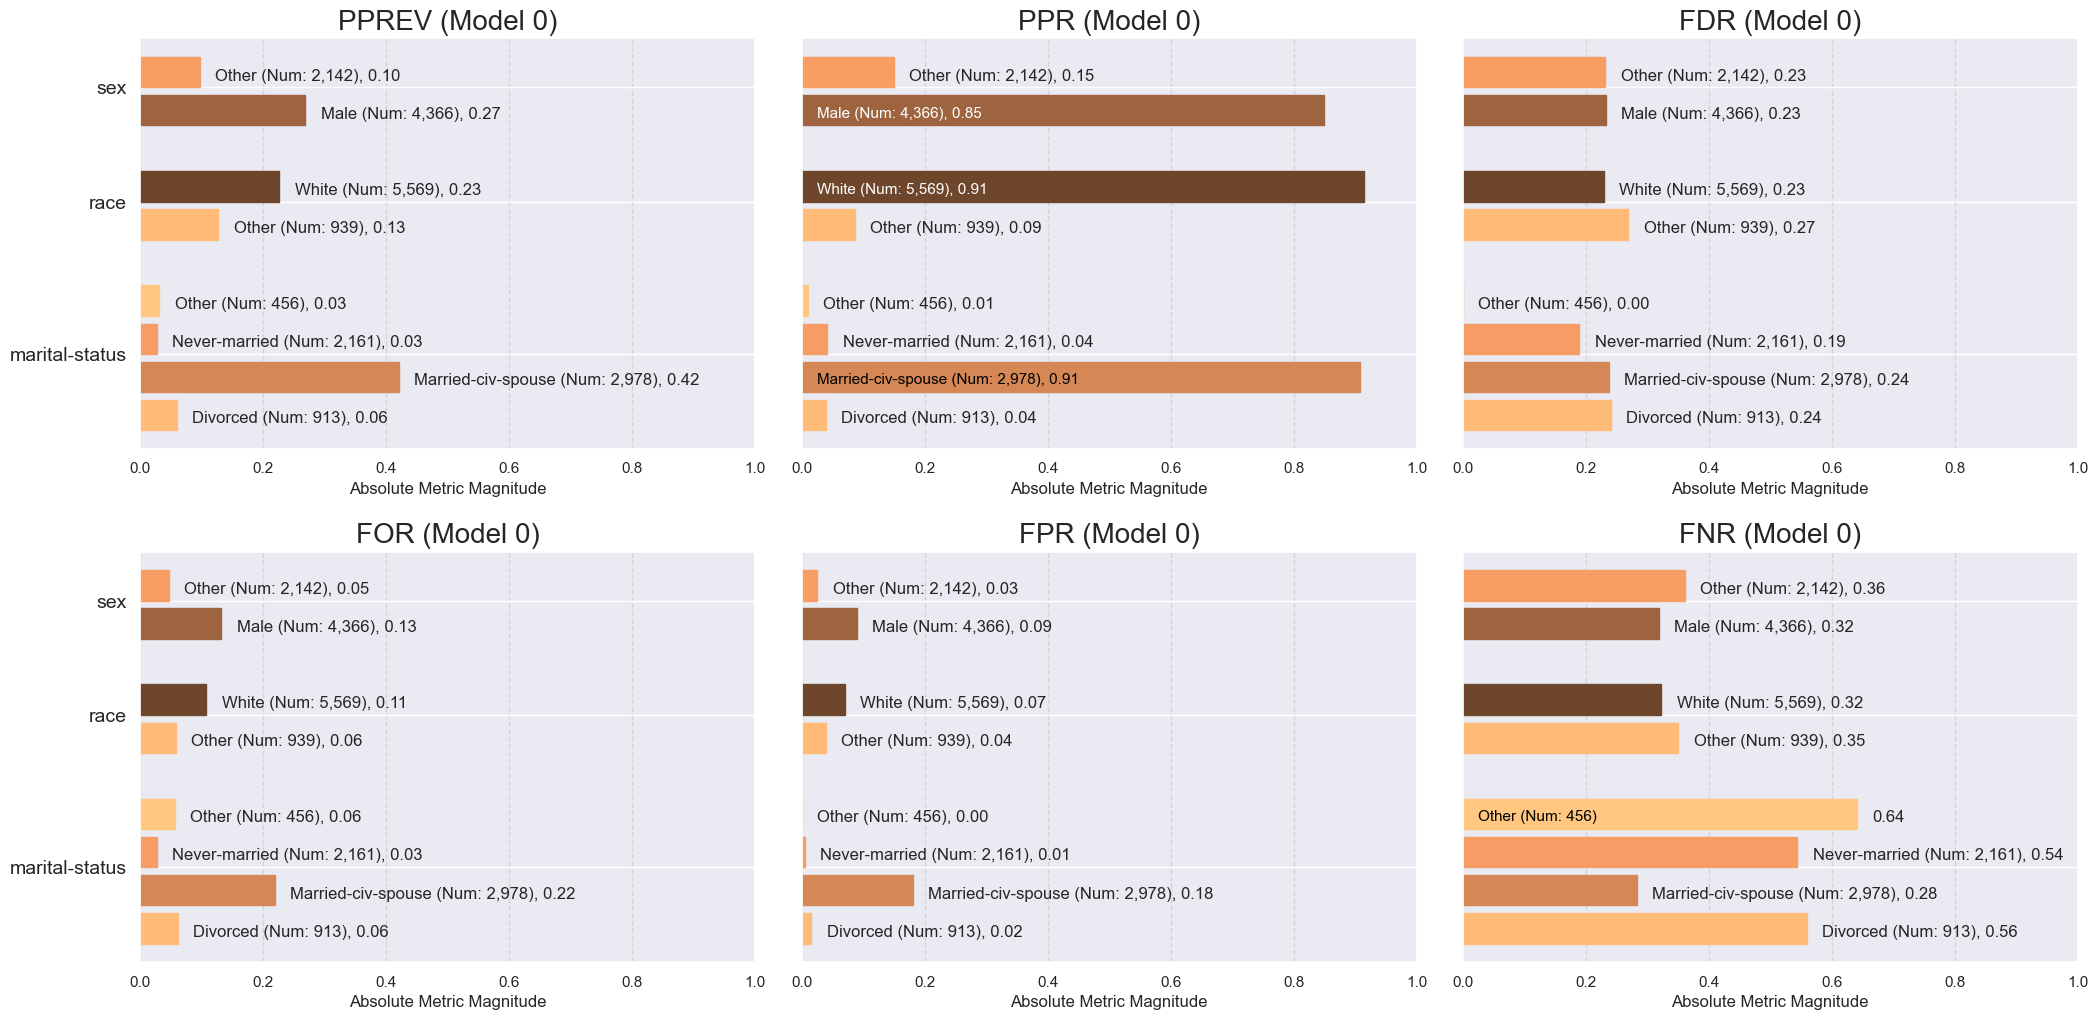

<Figure size 640x480 with 0 Axes>

In [45]:
fnr = aqp.plot_group_metric_all(xtab[(group_size_fr >= 0.01) & xtab['attribute_name'].isin(['marital-status', 'race', 'sex'])], ncols = 3)

### Disparsity levels across groups w.r.t. majority group

In [46]:
# define major groups
ref_group = {}
for c in cat_features + [n + '-qcut' for n in qcut_cols]:
    ref_group[c] = df_aq[c].value_counts().index[0]

bias = Bias()
bias_df = bias.get_disparity_predefined_groups(
    xtab, original_df = df_aq,
    ref_groups_dict = ref_group,
    alpha = 0.05, check_significance = True, mask_significance=True)

get_disparity_predefined_group()


/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.9/site-packages/aequitas/bias.py:606: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, difference_significance_p = stats.ttest_ind(
/home/biddy/miniconda3/envs/udacity-mldevops-3rd-project/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/biddy/minicond

In [47]:
metric = 'npv'
bias_df.loc[
    (bias_df[metric + '_significance'] == True) & bias_df['attribute_name'].isin(['marital-status', 'race', 'sex', 'native-country']), 
    ['attribute_name', 'attribute_value', 'group_size', 'label_value_significance', 'score_significance', metric + '_disparity', metric + '_significance', metric + '_ref_group_value']
]

attribute_name attribute_value  group_size  label_value_significance  \
17  marital-status        Divorced         913                      True   
19  marital-status   Never-married        2161                      True   
20  marital-status           Other         456                     False   
38            race           Other         939                     False   
41             sex           Other        2142                     False   
44  native-country          Mexico         135                      True   
45  native-country           Other         319                     False   

   score_significance  npv_disparity  npv_significance npv_ref_group_value  
17               True       1.202208              True  Married-civ-spouse  
19               True       1.245598              True  Married-civ-spouse  
20              False       1.207294              True  Married-civ-spouse  
38              False       1.056168              True               White  
41              False       1.097852              True                Male  
44               True       1.082229              True       United-States  
45              False       1.045223              True       United-States

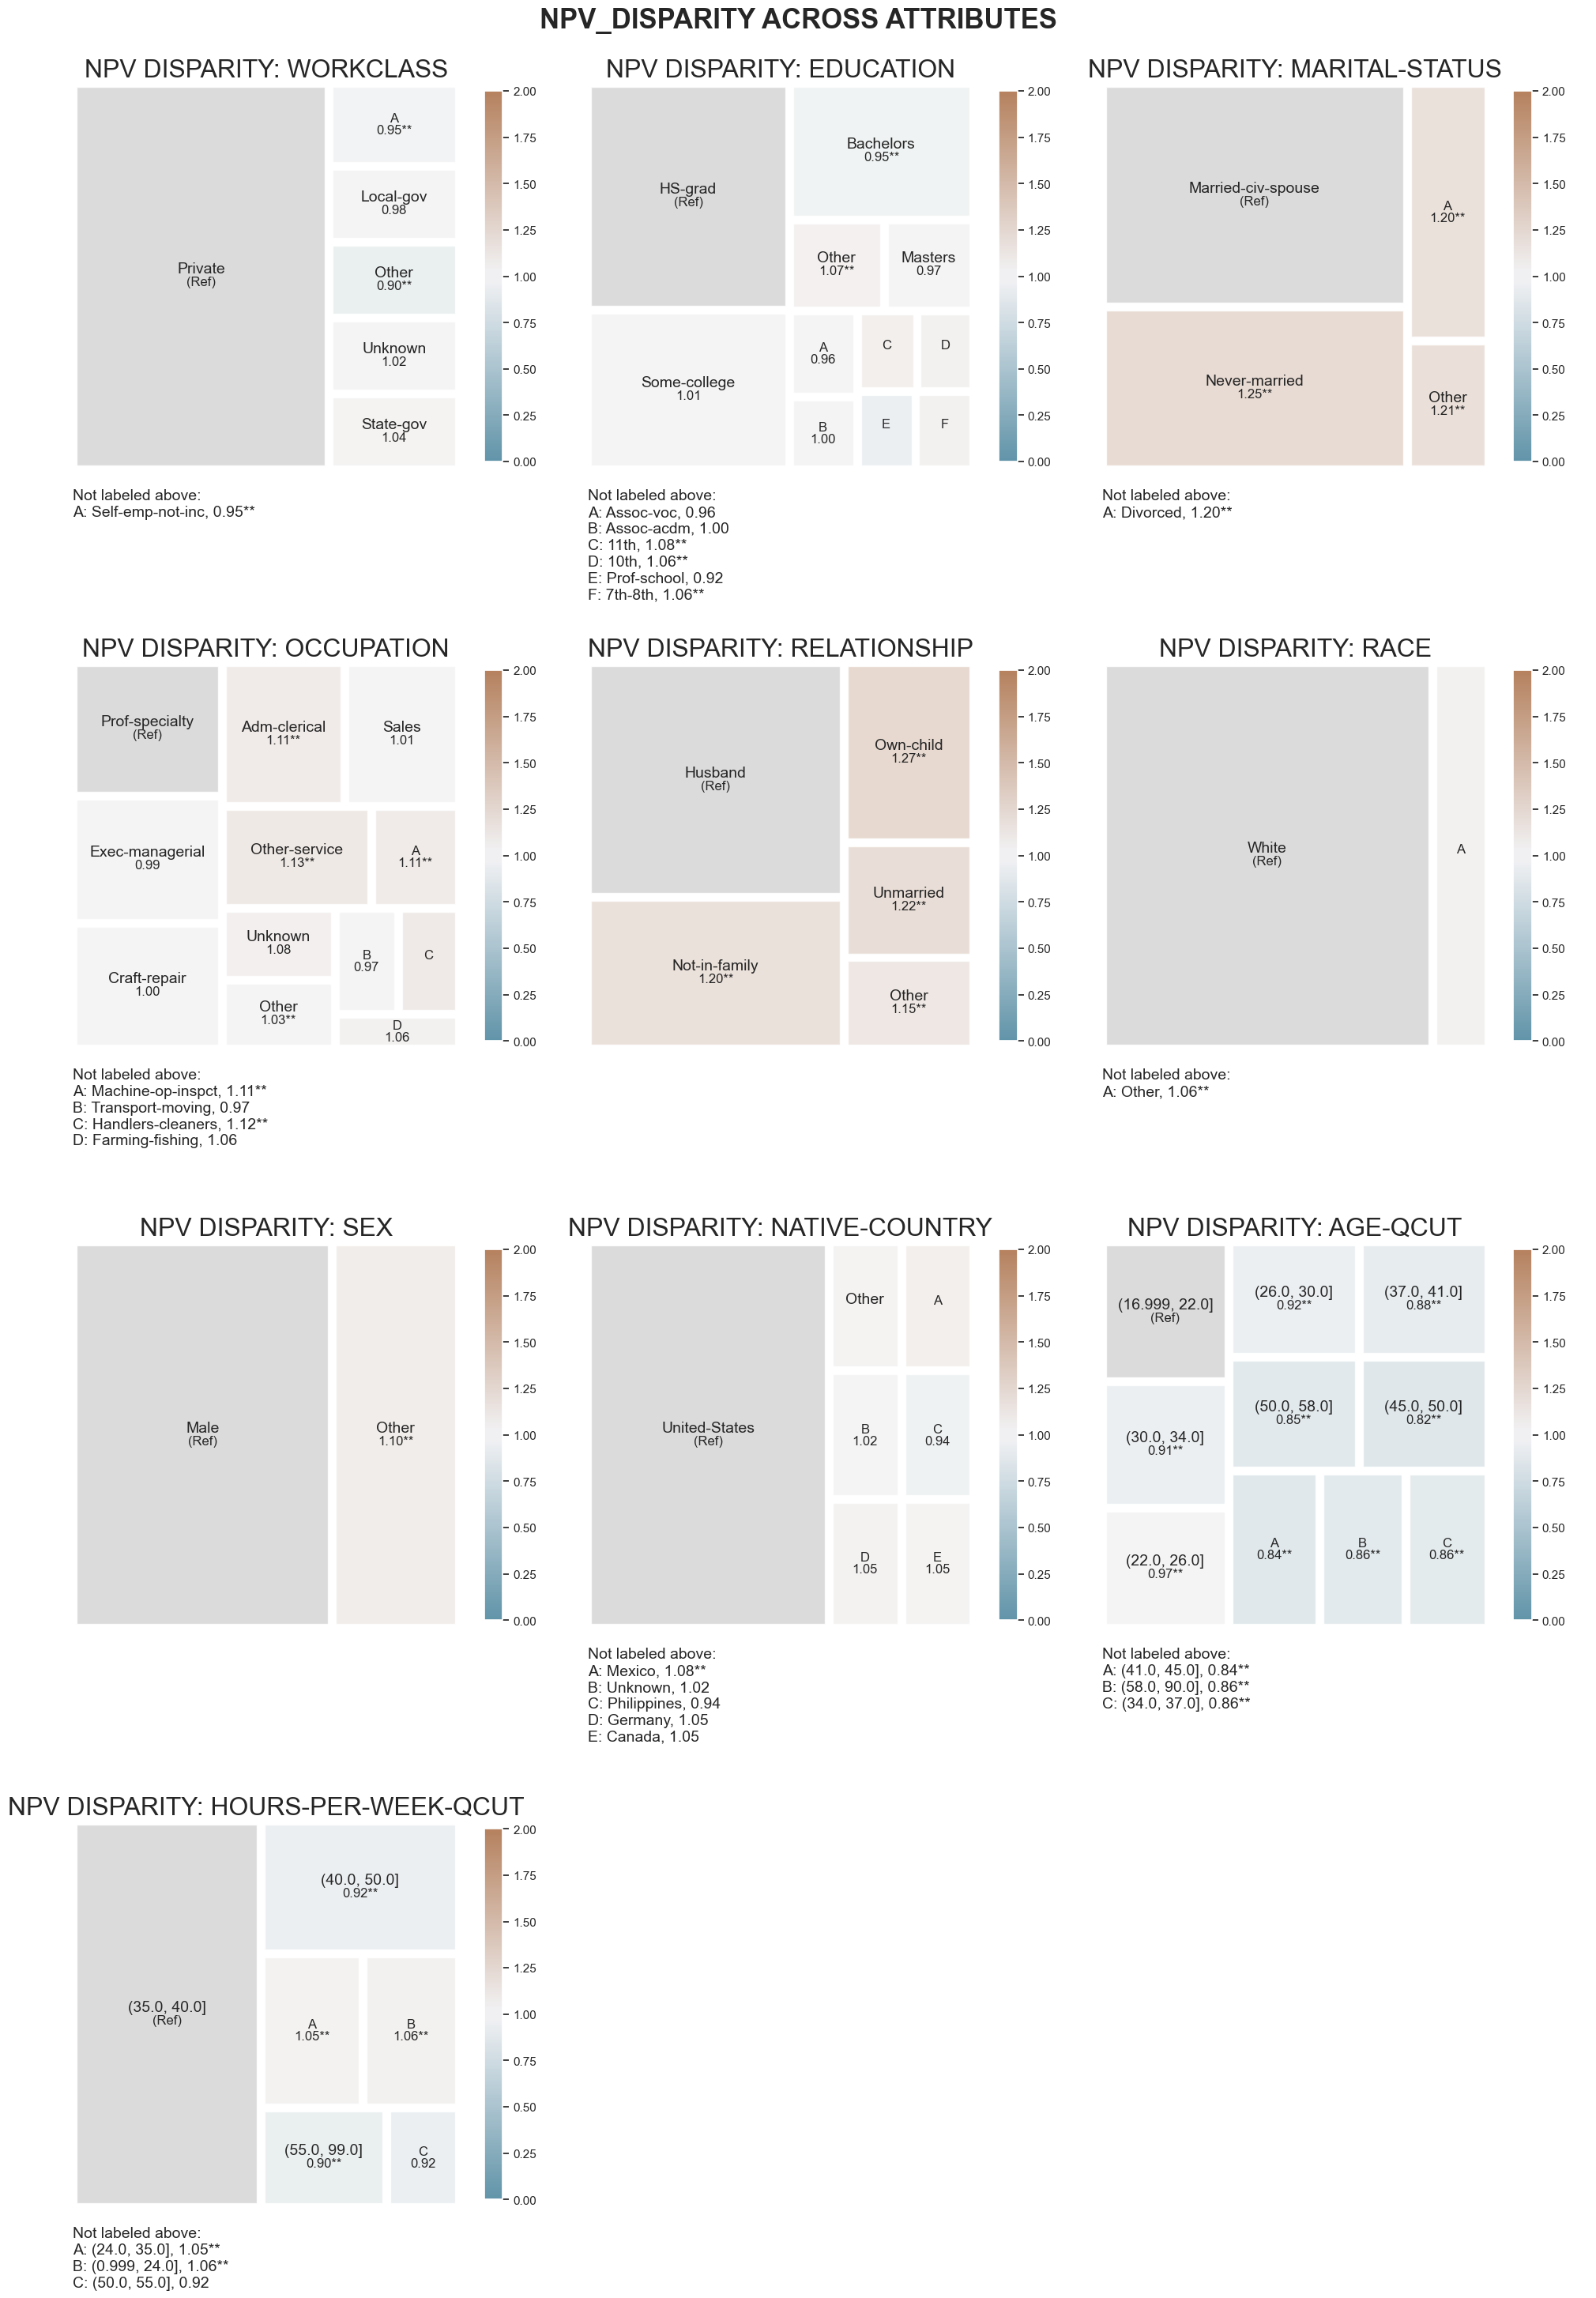

In [48]:
_ = aqp.plot_disparity_all(bias_df, metrics = [metric + '_disparity'], significance_alpha=0.05)

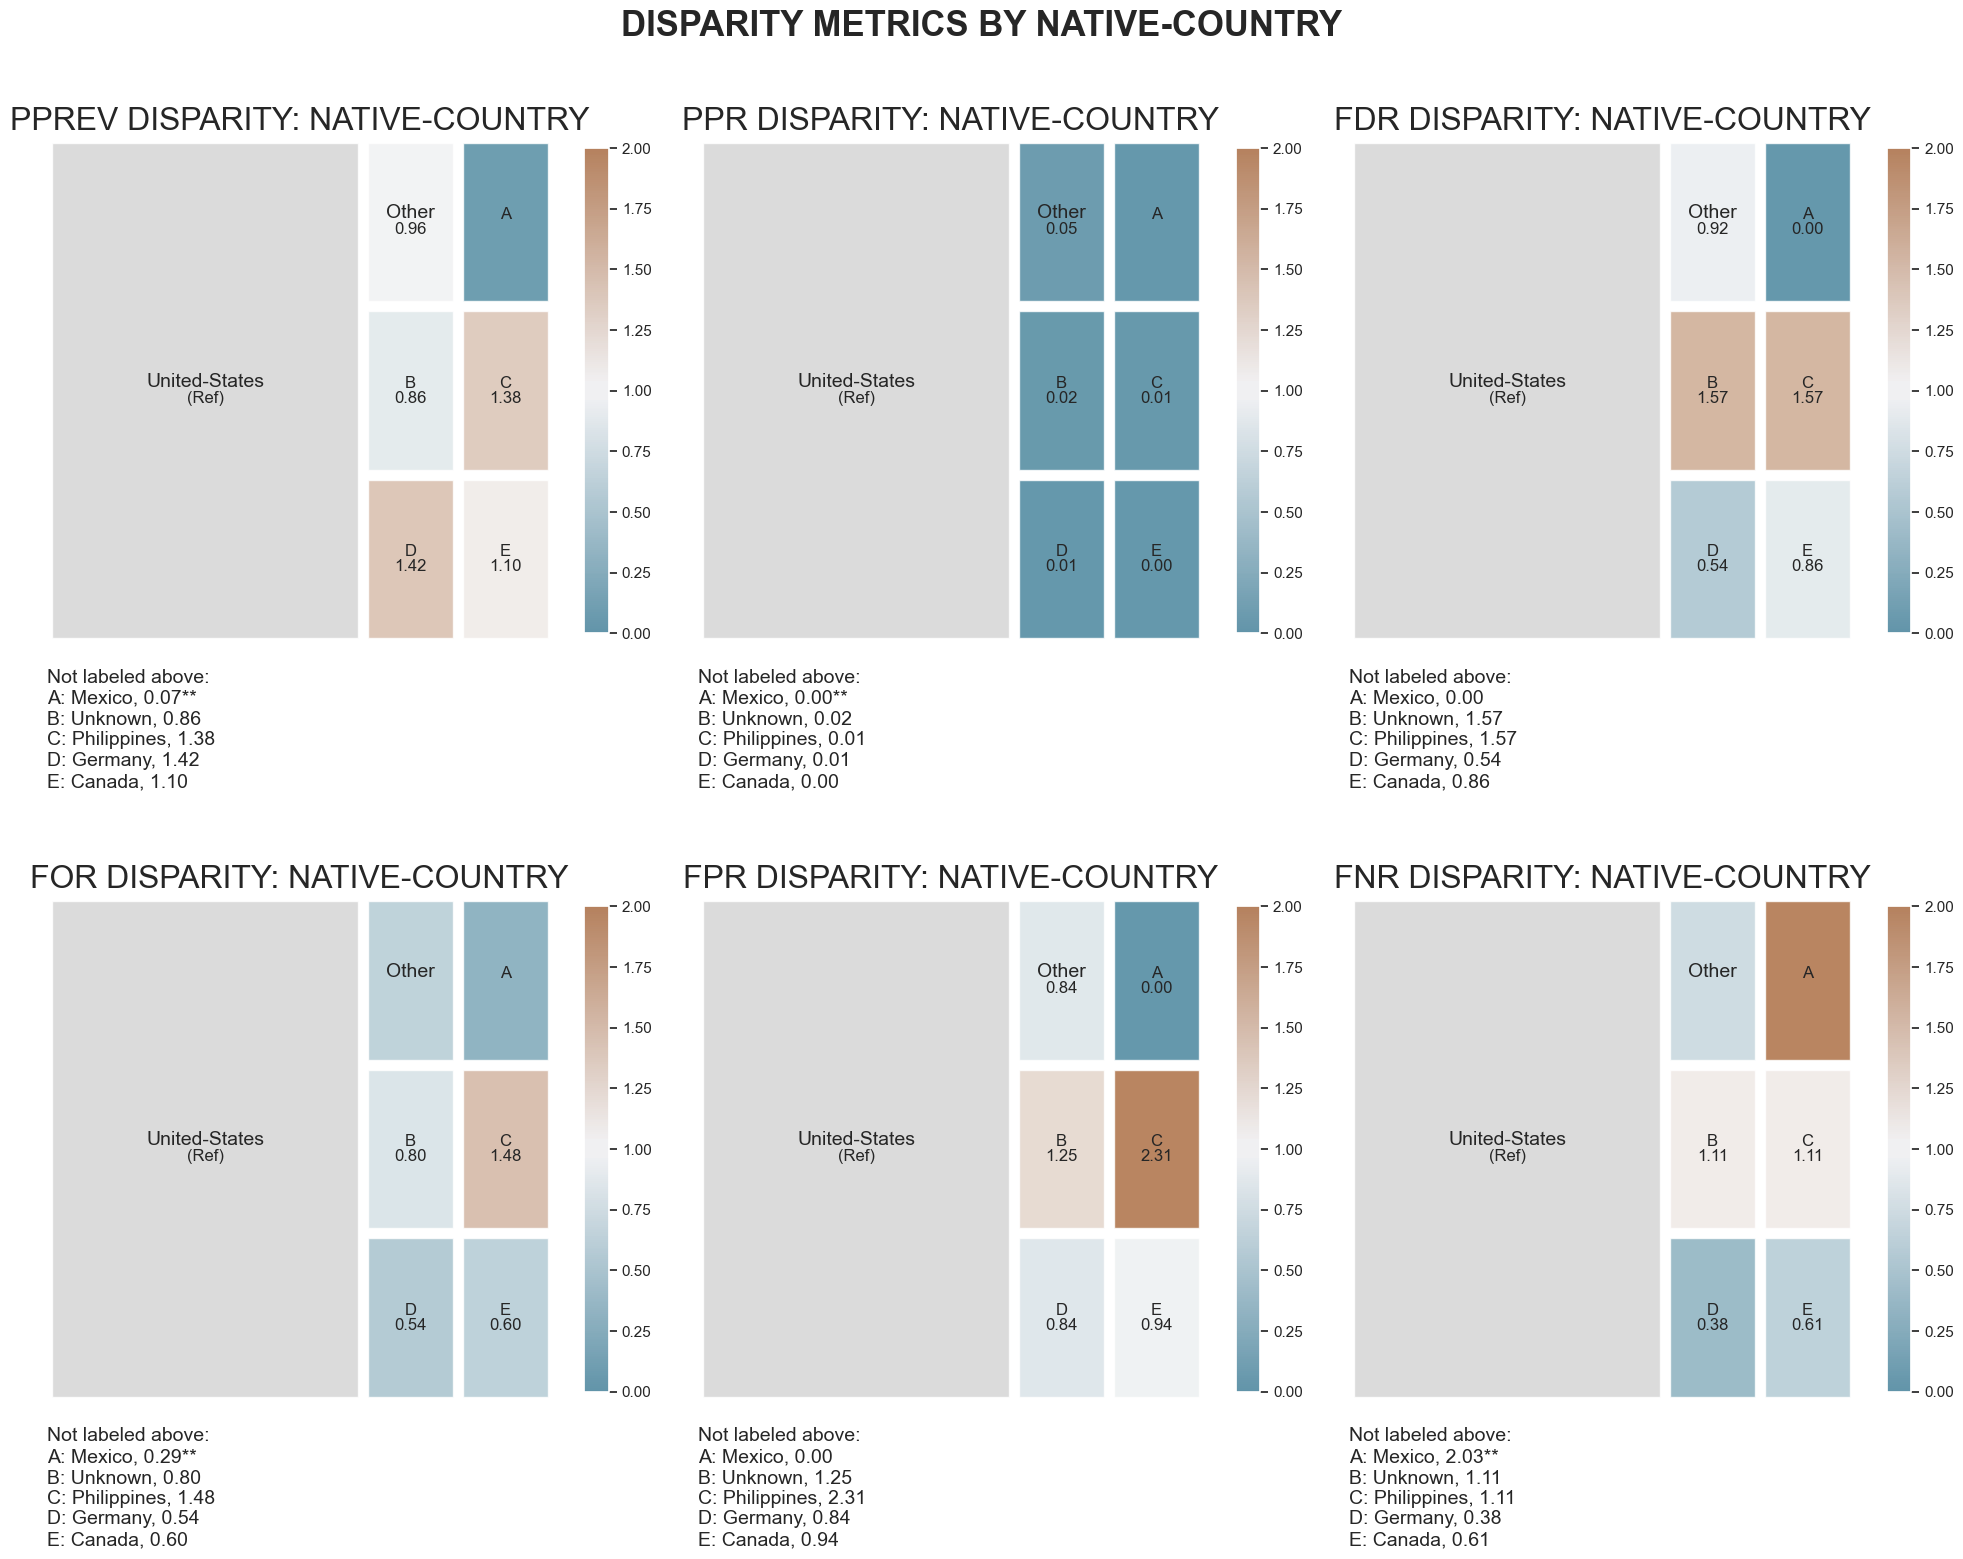

In [49]:
_ = aqp.plot_disparity_all(bias_df, attributes = ['native-country'], significance_alpha=0.05)

### Model and group level fairness

In [50]:
fairness = Fairness()
fairness_df = fairness.get_group_value_fairness(bias_df)

gof = fairness.get_overall_fairness(fairness_df)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

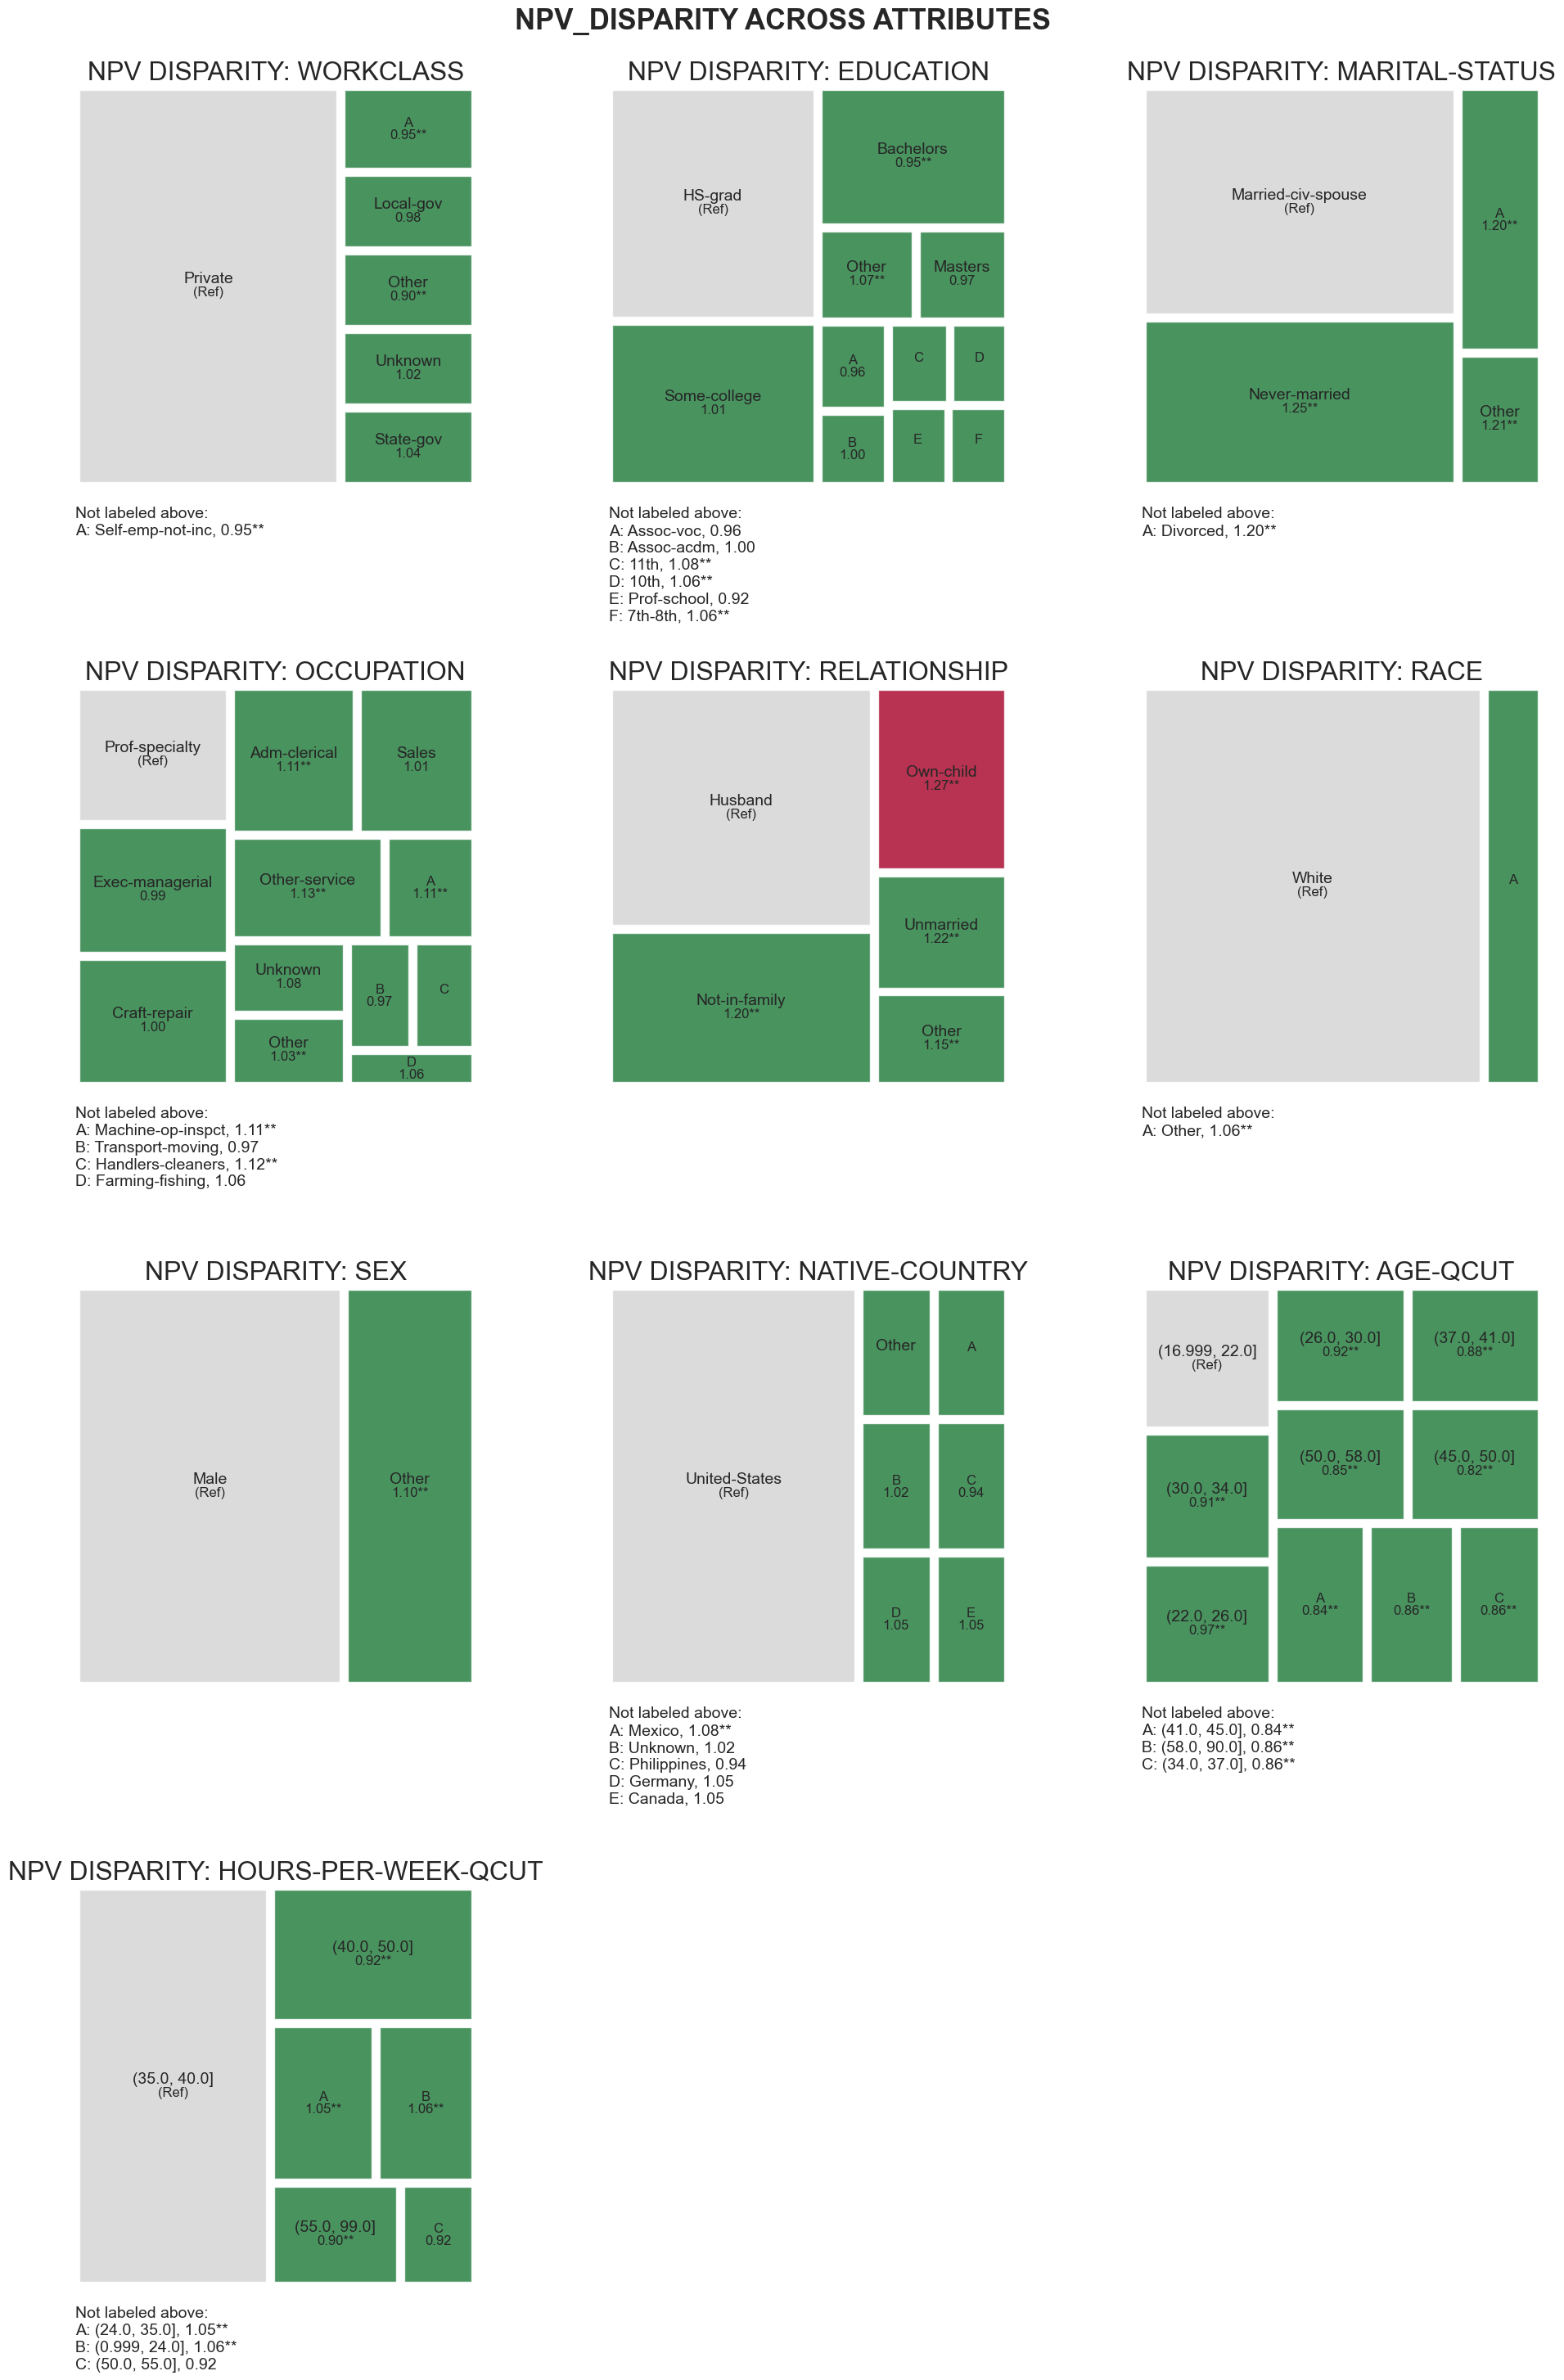

In [51]:
_ = aqp.plot_fairness_disparity_all(bias_df, metrics=[metric + '_disparity'], significance_alpha=0.05)